In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

## Importing the drivingProfile

In [2]:
drivingProfile = pd.read_csv('./parameter.csv')

In [3]:
drivingProfile

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [4]:
m = drivingProfile['m'][0]
lf = drivingProfile['lf'][0]
lr = drivingProfile['lr'][0]
Cf = drivingProfile['Cf'][0]
Cr = drivingProfile['Cr'][0]
Iz = drivingProfile['Iz'][0]
steering_ratio = drivingProfile['steering_ratio'][0]
Ts = drivingProfile['Sampling Period'][0]

## Importing inputs

In [5]:
inputs = pd.read_csv('./input2.csv')
inputs.head()

,samplingTime,DRV_DeltaSteer,Veh_Vx
0,0.000,0.0,30.000000
1,0.005,0.0,29.999664
2,0.010,0.0,29.998813
3,0.015,0.0,29.997596
4,0.020,0.0,29.996121


In [6]:
Time = inputs['samplingTime'].to_numpy()

print(Time)
print(len(Time))

deltaSteer = inputs['DRV_DeltaSteer'].to_numpy()

print(deltaSteer)
print(len(deltaSteer))

Vx = inputs['Veh_Vx'].to_numpy()

print(Vx)
print(len(Vx))

[0.000e+00 5.000e-03 1.000e-02 ... 9.990e+00 9.995e+00 1.000e+01]
2001
[0. 0. 0. ... 0. 0. 0.]
2001
[30.         29.99966417 29.99881271 ... 22.40103788 22.39962281
 22.39820783]
2001


In [7]:
n = math.floor(Ts/(Time[1]-Time[0]))
n

8

In [8]:
time = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

## Function to calculate parameters

In [9]:
def calculate_parameters(v_x):
  A = np.array([[(-2*Cf-2*Cr)/(m*v_x), -1-((2*Cf*lf - 2*Cr*lr)/(m*v_x*v_x))], [((2*Cr*lr)-(2*Cf*lf))/Iz, (-2*Cf*lf*lf-2*Cr*lr*lr)/(Iz*v_x)]])
  B = np.array([[(2*Cf)/(m*v_x), 0], [(2*Cf*lf)/Iz, 1/Iz]])
  C = np.array([[0, 1], [(-2*Cf-2*Cr)/m, -(2*Cf*lf-2*Cr*lr)/(m*v_x)]])
  D = np.array([[0, 0], [(2*Cf)/m, 0]])

  return [A, B, C, D]

## Controller Gain K

In [10]:
K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])

## Observer Gain L

In [11]:
L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])

## Matrix P
Positive definite P such that:  
![](./Screenshot%202023-05-30%20104347.png)  
`Amin, Amax` => Discrete-time closed loop matrices derived using the system equations fror v = vmin and v = vmax respectively.

In [12]:
P = np.array([[2, 1],[1,1]])
P

array([[2, 1],
       [1, 1]])

## Evaluating the system

In [13]:
# u = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
u = [np.array([[0], [0]])]
# x = [np.dot(np.linalg.inv(-K), u[0])]
x = [np.array([[0], [0]])]
# x_cap = [np.dot(np.linalg.inv(-K), u[0])]
x_cap = [np.array([[0], [0]])]
A, B, C, D = calculate_parameters(max(Vx))
y = [np.dot(C,x[0])]
y_cap = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity)):
  A, B, C, D = calculate_parameters(velocity[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y[i-1] - y_cap[i-1]

  x.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])))
  x_cap.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))+np.dot(L,r))

  y.append(np.dot(out.C, x[i-1])+np.dot(out.D, u[i-1]))
  y_cap.append(np.dot(out.C, x_cap[i-1])+np.dot(out.D, u[i-1]))

  utemp = np.dot(-K, x_cap[i]) + np.array([[(steeringAngle[i]*(math.pi/180)*steering_ratio)], [0]])
  # utemp[0][0] += steeringAngle[i]*(math.pi/180)*steering_ratio
  utemp[0][0] %= (2*math.pi)
  u.append(utemp)

In [14]:
np.array([[0], [0]])

array([[0],
       [0]])

## Extracting the values from the lists

### Extracting `yaw moment -> Mz` and `steering angle -> beta` from `u[]`

In [15]:
Mz = []
delta = []
for i in range(len(u)):
    Mz.append(u[i][1][0])
    delta.append(u[i][0][0])
print(len(Mz), len(delta))
print(Mz)
print(delta)

251 251
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -338.89699078337793, -1137.501525584509, -2070.2958345510006, -3013.0265019261687, -3950.206082020119, -4883.052797935337, -5811.721259356526, -6735.175648854156, -6983.4046193072245, -6987.1714830972005, -6961.732095305947, -6936.670754190812, -6903.308765963714, -5548.921559875303, -3731.9558611268644, -1894.0139435084816, -303833.1289581098, -413568.43027854845, -422590.36200716876, -417110.7799376694, -413007.8480740947, -410844.5451762963, -409046.1036533265, -406225.00161101436, -402186.21271657565, -397405.8798516957, -392064.17803340935, -386380.7229787243, -381032.5030699651, -37568

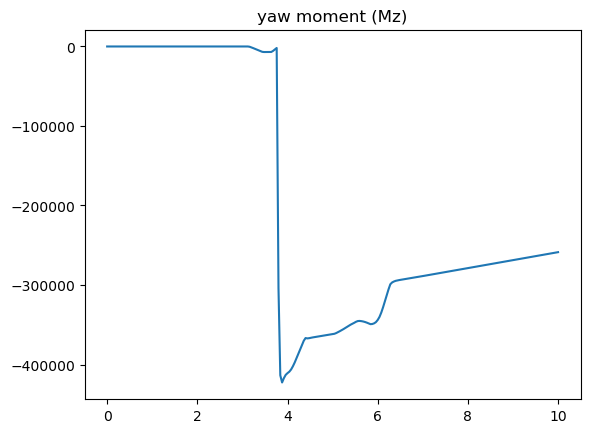

Text(0.5, 1.0, 'steering angle (delta)')

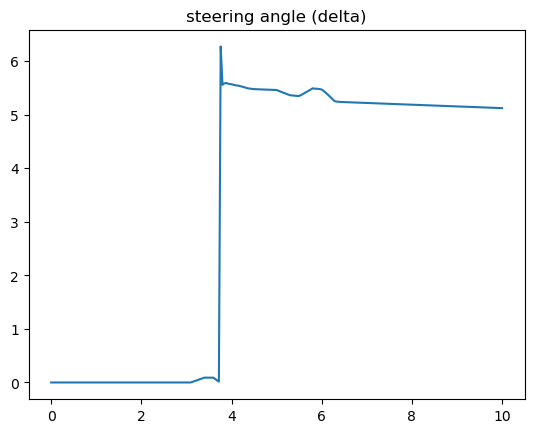

In [16]:
plt.plot(time, Mz)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time, delta)
plt.title("steering angle (delta)")

### Extracting `sideslip angle -> beta` and `yaw rate -> r` from `x[] and x_cap[]`

In [17]:
'''
0 -> beta
1 -> r
'''
r = []
beta = []

for i in range(len(x)):
    r.append(x[i][1][0])
    beta.append(x[i][0][0])

print(len(beta), len(r))
print(beta)
print(r)

251 251
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006744893095260035, 0.0020455620963549417, 0.003415329385455656, 0.004757406153899388, 0.00609667625311669, 0.007441087583019784, 0.008792784862353305, 0.010153703819124405, 0.010163443783707485, 0.010133901894338153, 0.01015576721469306, 0.01019624595929677, 0.010252597023939856, 0.007560008058174041, 0.004744696007490669, 0.0019701387542949873, 0.6794414312265026, 0.7094551040463918, 0.6904648561041257, 0.6860849248413656, 0.6882315873556453, 0.6919821465418465, 0.6955361834392594, 0.7002351818514431, 0.706867547054657, 0.7161978476516464, 0.7281631137384657, 0.7413374292792811, 0.75444

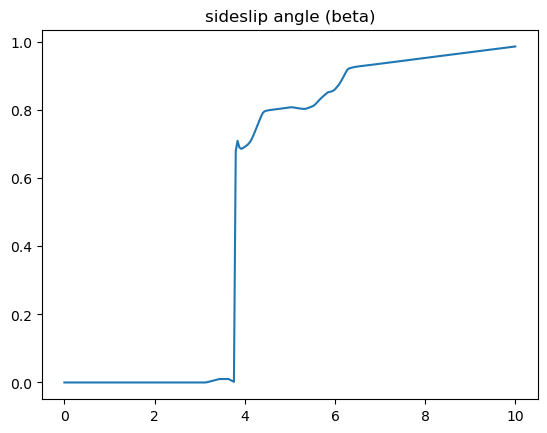

Text(0.5, 1.0, 'yaw rate (r)')

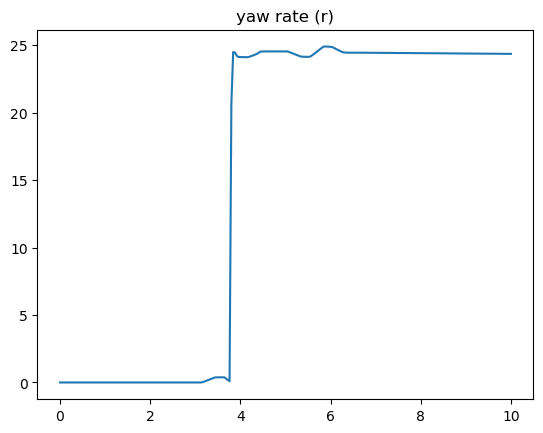

In [18]:
plt.plot(time, beta)
plt.title("sideslip angle (beta)")
plt.show()
plt.plot(time, r)
plt.title("yaw rate (r)")

In [19]:
'''
0 -> beta
1 -> r
'''
r_cap = []
beta_cap = []
for i in range(len(x)):
    r_cap.append(x_cap[i][1][0])
    beta_cap.append(x_cap[i][0][0])

print(len(beta_cap), len(r_cap))
print(beta_cap)
print(r_cap)

251 251
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006744893095260035, 0.0020455620963549417, 0.003415329385455656, 0.004757406153899388, 0.00609667625311669, 0.007441087583019784, 0.008792784862353305, 0.010153703819124405, 0.010163443783707485, 0.010133901894338153, 0.01015576721469306, 0.01019624595929677, 0.010252597023939856, 0.007560008058174041, 0.004744696007490669, 0.0019701387542949873, 0.6794414312265026, 0.7094551040463918, 0.6904648561041257, 0.6860849248413656, 0.6882315873556453, 0.6919821465418465, 0.6955361834392594, 0.7002351818514431, 0.706867547054657, 0.7161978476516464, 0.7281631137384657, 0.7413374292792811, 0.75444

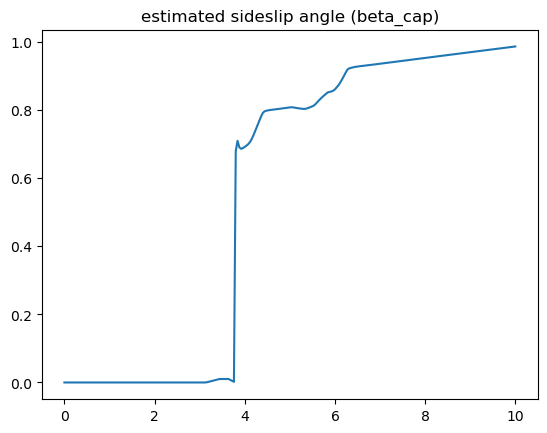

Text(0.5, 1.0, 'estaimated yaw rate (r_cap)')

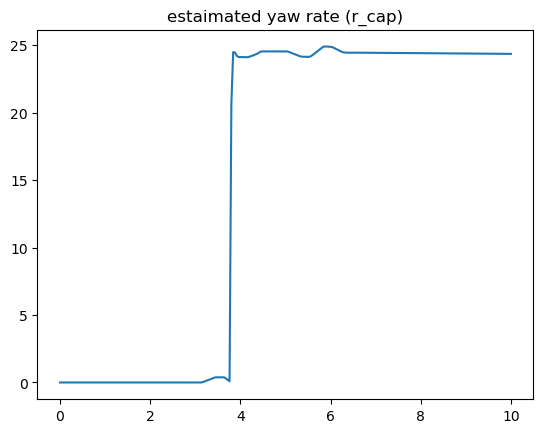

In [20]:
plt.plot(time, beta)
plt.title("estimated sideslip angle (beta_cap)")
plt.show()
plt.plot(time, r)
plt.title("estaimated yaw rate (r_cap)")

### Extracting `yaw rate -> r` and `inertial acceleration -> ay` from `y[] and y_cap[]`

In [21]:
'''
0 -> r
1 -> ay
'''
r1 = []
ay = []
for i in range(len(y)):
    r1.append(y[i][0][0])
    ay.append(y[i][1][0])

print(len(r1), len(ay))
print(r1)
print(ay)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021622895375768426, 0.06894182497728456, 0.1203546880899185, 0.17161131830354262, 0.2226509690691108, 0.27364331885960314, 0.32462881445703407, 0.3756079124175379, 0.38338336736886114, 0.38300709180275616, 0.3825908623664809, 0.3824961001772601, 0.38241099205140117, 0.296045608231992, 0.19344964373374735, 0.0908888054490651, 20.62991116092098, 24.49520877463207, 24.455770262296014, 24.214792579584774, 24.124690802723904, 24.120779745683265, 24.124787506926193, 24.116490839239262, 24.103033392946998, 24.111747084313848, 24.147109661087843, 24.192118496716823, 24.246357884330152, 24.2

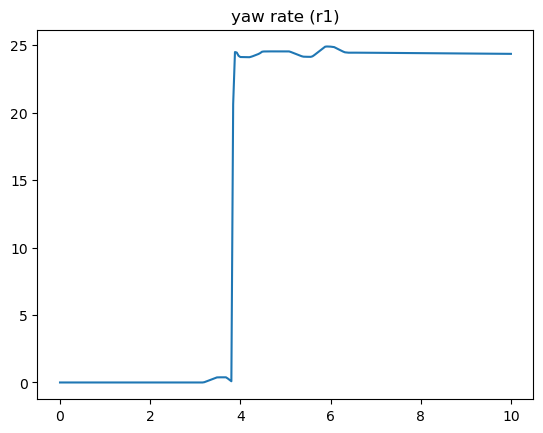

Text(0.5, 1.0, 'inertial acceleration (ay)')

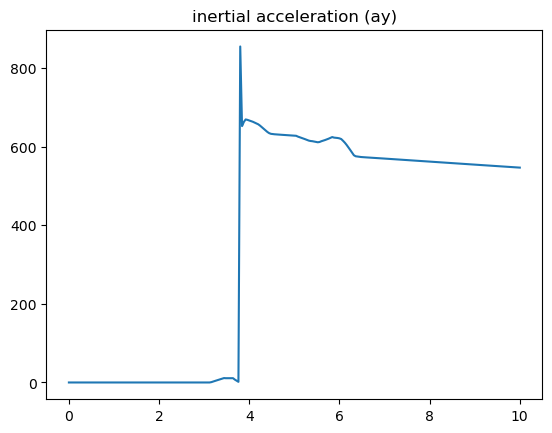

In [22]:
plt.plot(time, r1)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("inertial acceleration (ay)")

In [23]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []
for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8912587422956468, 2.481859227452582, 3.899761452290072, 5.349444770523026, 6.812798814568839, 8.276338637289205, 9.737262956884553, 11.194882724521618, 10.865803310681315, 10.921564395215642, 10.936562480045414, 10.924616622704843, 10.906456284923093, 7.316728352327922, 4.517282373752454, 1.6553052293965302, 854.3765693452312, 651.9059549123018, 662.4567298329322, 668.8447155520208, 667.7808664205693, 666.1869356994108, 664.4127496505893, 662.9142723929874, 660.859099240809, 658.7699600657465, 656.452391305573, 653.0305085471255, 649.0311711581228, 645.1441261417135, 641.3213912028714, 6

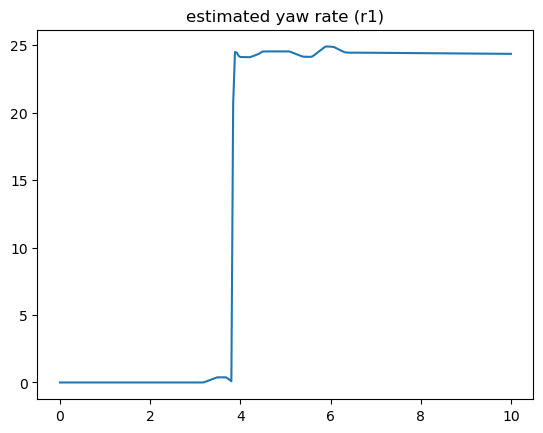

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

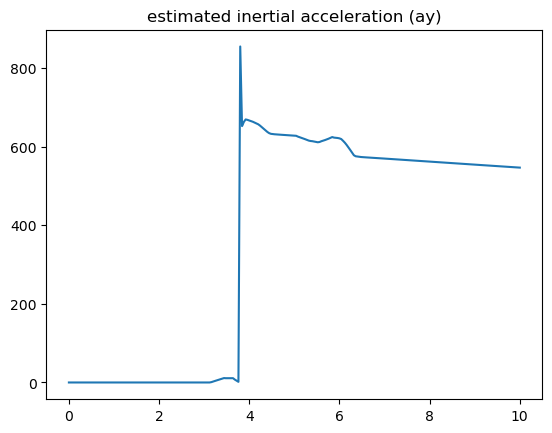

In [24]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

---

## Inputs and Outputs

In [25]:
inputs = [[], []]

for i in range(len(u)):
    inputs[0].append(u[i][0][0])
    inputs[1].append(u[i][1][0])

inputs = np.array(inputs)

In [26]:
outputs = [[], []]

for i in range(len(y)):
    outputs[0].append(y[i][0][0])
    outputs[1].append(y[i][1][0])

outputs = np.array(outputs)

# Inserting noise to the output data

In [27]:
from sippy import functionset as fset

In [28]:
size = len(inputs[0])
noise = fset.white_noise_var(size, [0.001, 0.01])

In [29]:
netOuput = outputs + noise

In [30]:
netOuput.shape

(2, 251)

---

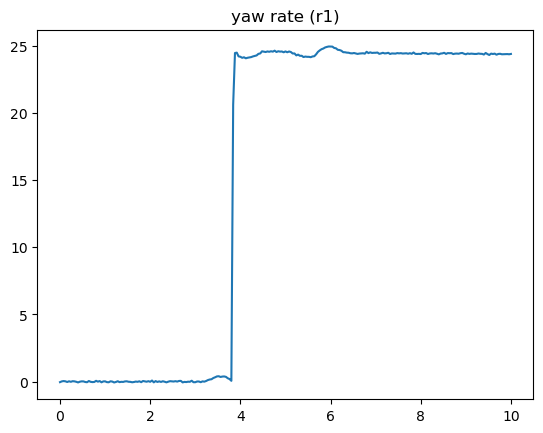

Text(0.5, 1.0, 'inertial acceleration (ay)')

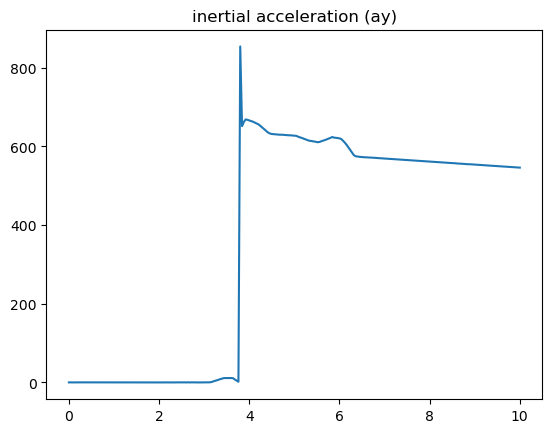

In [31]:
plt.plot(time, netOuput[0])
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, netOuput[1])
plt.title("inertial acceleration (ay)")

In [43]:
velocity

[30.0,
 29.98896577,
 29.97307045,
 29.95719028,
 29.94132263,
 29.92543387,
 29.90954455,
 29.8936593,
 29.8777837,
 29.86192225,
 29.84607964,
 29.83025774,
 29.8144528,
 29.79866568,
 29.78289527,
 29.76713995,
 29.75139817,
 29.73566847,
 29.71994965,
 29.70424078,
 29.68854101,
 29.67284976,
 29.65716811,
 29.64149601,
 29.6258336,
 29.6101811,
 29.59453874,
 29.57890674,
 29.56328529,
 29.54767457,
 29.5320747,
 29.51648588,
 29.50090803,
 29.48534106,
 29.46978495,
 29.45423961,
 29.43870497,
 29.42318096,
 29.40766752,
 29.39216459,
 29.37667212,
 29.36119009,
 29.34571852,
 29.33025739,
 29.31480667,
 29.29936638,
 29.28393651,
 29.26851706,
 29.25310802,
 29.23770939,
 29.22232118,
 29.20694336,
 29.19157593,
 29.17621889,
 29.1608722,
 29.14553586,
 29.13020985,
 29.11489416,
 29.09958877,
 29.08429366,
 29.06900883,
 29.05373425,
 29.03846992,
 29.02321583,
 29.00797195,
 28.99273829,
 28.97751483,
 28.96230155,
 28.94709846,
 28.93190553,
 28.91672276,
 28.90155013,
 28.88

---
---

# SYSTEM IDENTIFICATION USING **SIPPY**

In [32]:
from sippy import system_identification
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Using State-Space form

In [33]:
METHOD = [
    'N4SID',
    'CVA', 
    'MOESP', 
    'PARSIM-S', 
    'PARSIM-P', 
    'PARSIM-K'
    ]

lege = ['System']

In [34]:
sysId = system_identification(netOuput, inputs, METHOD[1])

In [35]:
x_id, y_id = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs, sysId.x0)

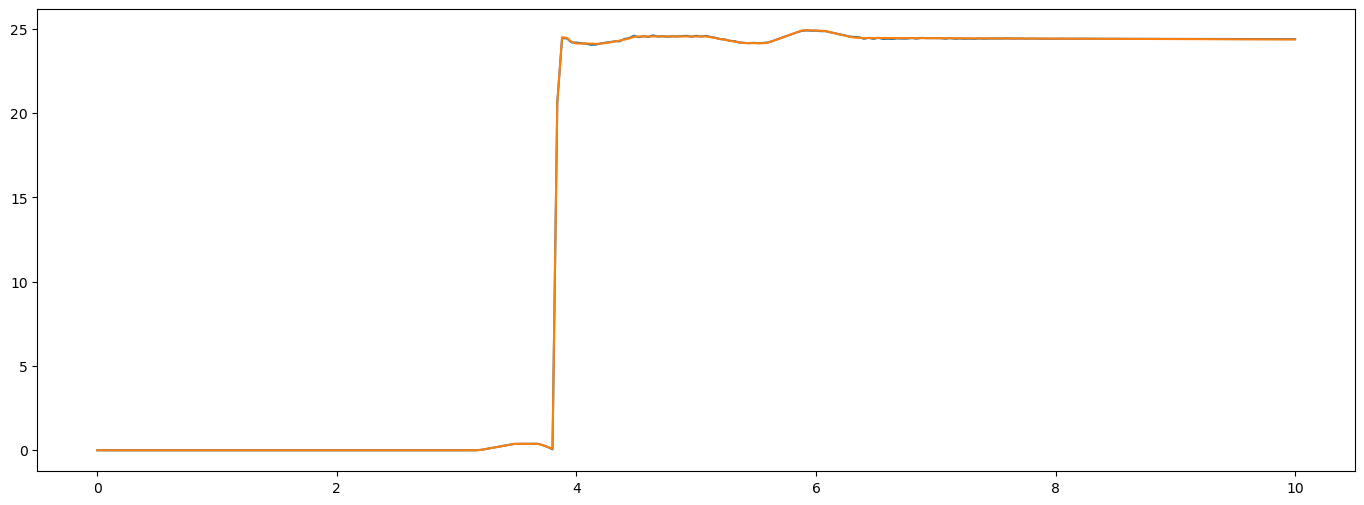

In [36]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[0])
plt.plot(time, outputs[0])

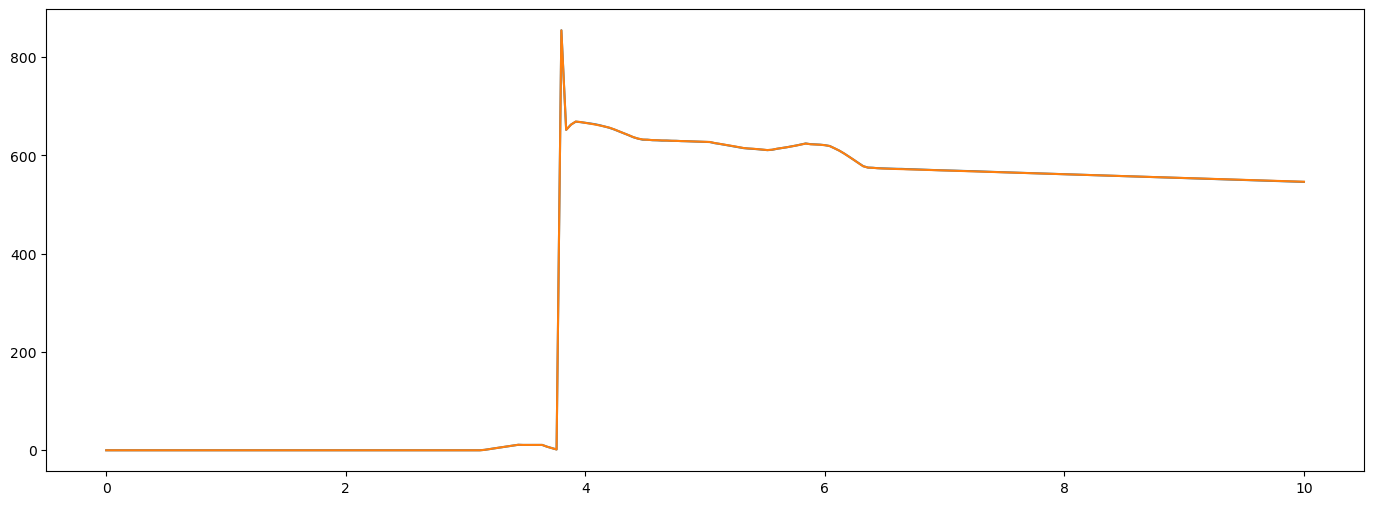

In [37]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[1])
plt.plot(time, outputs[1])

In [38]:
# for yaw rate
r2_score(netOuput[0], y_id[0])

0.9999919713799997

In [39]:
# for inretial acceleration ay
r2_score(netOuput[1], y_id[1])

0.9999996362485702

---

In [40]:
# for yaw rate
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.03355426227320828

In [41]:
# for inretial acceleration ay
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.03355426227320828

---
# Circular Maneuver
---

In [42]:
circular_data = pd.read_csv('./Circular maneuver/circular_input.csv')
circular_data.head()

FileNotFoundError: [Errno 2] No such file or directory: './Circular maneuver/circular_input.csv'

In [ ]:
Time = circular_data['samplingTime'].to_numpy()

deltaSteer = circular_data['Drv_DeltaSteer'].to_numpy()

Vx = circular_data['Veh_Vx'].to_numpy()

n = math.floor(Ts/(Time[1]-Time[0]))

time_circular = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle_circular = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity_circular = [Vx[i] for i in range(len(Vx)) if i%n==0]

In [ ]:
u_circular = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x_circular = [np.dot(np.linalg.inv(-K), u[0])]
x_cap_circular = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y_circular = [np.dot(C,x[0])]
y_cap_circular = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity_circular)):
  A, B, C, D = calculate_parameters(velocity_circular[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y_circular[i-1] - y_cap_circular[i-1]

  x_circular.append(np.array(np.dot(out.A, x_circular[i-1])+np.dot(out.B, u_circular[i-1])))
  x_cap_circular.append(np.array(np.dot(out.A, x_circular[i-1])+np.dot(out.B, u_circular[i-1]))+np.dot(L,r))

  y_circular.append(np.dot(out.C, x_circular[i-1])+np.dot(out.D, u_circular[i-1]))
  y_cap_circular.append(np.dot(out.C, x_cap_circular[i-1])+np.dot(out.D, u_circular[i-1]))

  utemp = np.dot(-K, x_circular[i])
  utemp[0][0] += steeringAngle_circular[i]*(math.pi/180)*steering_ratio
  u_circular.append(utemp)

In [ ]:
Mz_circular = []
delta_circular = []
for i in range(len(u_circular)):
    Mz_circular.append(u_circular[i][1][0])
    delta_circular.append(u_circular[i][0][0])
print(len(Mz_circular), len(delta_circular))
print(Mz_circular)
print(delta_circular)

In [ ]:
plt.plot(time_circular, Mz_circular)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time_circular, Mz_circular)
plt.title("steering angle (delta)")

In [ ]:
inputs_circular = [[], []]

for i in range(len(u_circular)):
    inputs_circular[0].append(u_circular[i][0][0])
    inputs_circular[1].append(u_circular[i][1][0])

inputs_circular = np.array(inputs_circular)

In [ ]:
'''
0 -> r
1 -> ay
'''
r1_circular = []
ay_circular = []

for i in range(len(y_circular)):
    r1_circular.append(y_circular[i][0][0])
    ay_circular.append(y_circular[i][1][0])

print(len(r1_circular), len(ay_circular))
print(r1_circular)
print(ay_circular)

In [ ]:
plt.plot(time, r1_circular)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay_circular)
plt.title("inertial acceleration (ay)")

In [ ]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

In [ ]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

In [ ]:
outputs_circular = [[], []]

for i in range(len(y_circular)):
    outputs_circular[0].append(y_circular[i][0][0])
    outputs_circular[1].append(y_circular[i][1][0])

outputs_circular = np.array(outputs_circular)

In [ ]:
x_id_circular, y_id_circular = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs_circular, sysId.x0)

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[0],label='y_id')
plt.plot(time, outputs_circular[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[1], label='y_id')
plt.plot(time, outputs_circular[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [ ]:
print(r2_score(outputs_circular[0], y_id_circular[0])) # r2
print(math.sqrt(mean_squared_error(outputs_circular[0], y_id_circular[0]))) #rmse

In [ ]:
print(r2_score(outputs_circular[1], y_id_circular[1])) # r2
print(math.sqrt(mean_squared_error(outputs_circular[1], y_id_circular[1]))) # rmse

In [ ]:
from sippy import functionset as fset

size = len(inputs[0])
noise_circular = fset.white_noise_var(size, [0.001, 0.01])

netOutput_circular = outputs_circular + noise_circular

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[0],label='y_id')
plt.plot(time, netOutput_circular[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [ ]:
print(r2_score(netOutput_circular[0], y_id_circular[0])) # r2
print(math.sqrt(mean_squared_error(netOutput_circular[0], y_id_circular[0]))) #rmse

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[1], label='y_id')
plt.plot(time, netOutput_circular[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [ ]:
print(r2_score(netOutput_circular[1], y_id_circular[1])) # r2
print(math.sqrt(mean_squared_error(netOutput_circular[1], y_id_circular[1]))) # rmse

---
# VDA maneuver
---

In [ ]:
vda_data = pd.read_csv('./VDA/VDA_input.csv')
vda_data.head()
# hf_data.shape

In [ ]:
Time = vda_data['samplingTime'].to_numpy()

deltaSteer = vda_data['Drv_DeltaSteer'].to_numpy()

Vx = vda_data['Veh_Vx'].to_numpy()

n = math.floor(Ts/(Time[1]-Time[0]))

time_vda = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle_vda = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity_vda = [Vx[i] for i in range(len(Vx)) if i%n==0]

In [ ]:
u_vda = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x_vda = [np.dot(np.linalg.inv(-K), u[0])]
x_cap_vda = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y_vda = [np.dot(C,x[0])]
y_cap_vda = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity_vda)):
  A, B, C, D = calculate_parameters(velocity_vda[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y_vda[i-1] - y_cap_vda[i-1]

  x_vda.append(np.array(np.dot(out.A, x_vda[i-1])+np.dot(out.B, u_vda[i-1])))
  x_cap_vda.append(np.array(np.dot(out.A, x_vda[i-1])+np.dot(out.B, u_vda[i-1]))+np.dot(L,r))

  y_vda.append(np.dot(out.C, x_vda[i-1])+np.dot(out.D, u_vda[i-1]))
  y_cap_vda.append(np.dot(out.C, x_cap_vda[i-1])+np.dot(out.D, u_vda[i-1]))

  utemp = np.dot(-K, x_vda[i])
  utemp[0][0] += steeringAngle_vda[i]*(math.pi/180)*steering_ratio
  u_vda.append(utemp)

In [ ]:
Mz_vda = []
delta_vda = []
for i in range(len(u_vda)):
    Mz_vda.append(u_vda[i][1][0])
    delta_vda.append(u_vda[i][0][0])
print(len(Mz_vda), len(delta_vda))
print(Mz_vda)
print(delta_vda)

In [ ]:
plt.plot(time_vda, Mz_vda)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time_vda, delta_vda)
plt.title("steering angle (delta)")

In [ ]:
inputs_vda = [[], []]

for i in range(len(u_vda)):
    inputs_vda[0].append(u_vda[i][0][0])
    inputs_vda[1].append(u_vda[i][1][0])

inputs_vda = np.array(inputs_vda)

In [ ]:
'''
0 -> r
1 -> ay
'''
r1_vda = []
ay_vda = []

for i in range(len(y_vda)):
    r1_vda.append(y_vda[i][0][0])
    ay_vda.append(y_vda[i][1][0])

print(len(r1_vda), len(ay_vda))
print(r1_vda)
print(ay_vda)

In [ ]:
plt.plot(time_vda, r1_vda)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time_vda, ay_vda)
plt.title("inertial acceleration (ay)")

In [ ]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

In [ ]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

In [ ]:
outputs_vda = [[], []]

for i in range(len(y_vda)):
    outputs_vda[0].append(y_vda[i][0][0])
    outputs_vda[1].append(y_vda[i][1][0])

outputs_vda = np.array(outputs_vda)

In [ ]:
x_id_vda, y_id_vda = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs_vda, sysId.x0)

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[0],label='y_id')
plt.plot(time_vda, outputs_vda[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[1], label='y_id')
plt.plot(time_vda, outputs_vda[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [ ]:
print(r2_score(outputs_vda[0], y_id_vda[0])) # r2
print(math.sqrt(mean_squared_error(outputs_vda[0], y_id_vda[0]))) #rmse

In [ ]:
print(r2_score(outputs_vda[1], y_id_vda[1])) # r2
print(math.sqrt(mean_squared_error(outputs_vda[1], y_id_vda[1]))) # rmse

In [ ]:
from sippy import functionset as fset

size = len(inputs_vda[0])
noise_vda = fset.white_noise_var(size, [0.001, 0.01])

netOutput_vda = outputs_vda + noise_vda

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[0],label='y_id')
plt.plot(time_vda, netOutput_vda[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [ ]:
print(r2_score(netOutput_vda[0], y_id_vda[0])) # r2
print(math.sqrt(mean_squared_error(netOutput_vda[0], y_id_vda[0]))) #rmse

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[1], label='y_id')
plt.plot(time_vda, netOutput_vda[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [ ]:
print(r2_score(netOutput_vda[1], y_id_vda[1])) # r2
print(math.sqrt(mean_squared_error(netOutput_vda[1], y_id_vda[1]))) # rmse

---
# High Frequency
---

In [ ]:
hf_data = pd.read_csv('./High frq/HighFrq_input.csv')
hf_data.head()

In [ ]:
# hf_data = hf_data[0:2000]
hf_data.shape

In [ ]:
Time = hf_data['Time'].to_numpy()

deltaSteer = hf_data['Drv_DeltaSteer'].to_numpy()

Vx = hf_data['Veh_Vx'].to_numpy()

n = math.floor(Ts/(Time[1]-Time[0]))

time_hf = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle_hf = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity_hf = [Vx[i] for i in range(len(Vx)) if i%n==0]

In [ ]:
u_hf = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x_hf = [np.dot(np.linalg.inv(-K), u_hf[0])]
x_cap_hf = [np.dot(np.linalg.inv(-K), u_hf[0])]
A, B, C, D = calculate_parameters(max(Vx))
y_hf = [np.dot(C,x_hf[0])]
y_cap_hf = [np.dot(C,x_cap_hf[0])]

for i in range(1, len(velocity_hf)):
  A, B, C, D = calculate_parameters(velocity_hf[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y_hf[i-1] - y_cap_hf[i-1]

  x_hf.append(np.array(np.dot(out.A, x_hf[i-1])+np.dot(out.B, u_hf[i-1])))
  x_cap_hf.append(np.array(np.dot(out.A, x_hf[i-1])+np.dot(out.B, u_hf[i-1]))+np.dot(L,r))

  y_hf.append(np.dot(out.C, x_hf[i-1])+np.dot(out.D, u_hf[i-1]))
  y_cap_hf.append(np.dot(out.C, x_cap_hf[i-1])+np.dot(out.D, u_hf[i-1]))

  utemp = np.dot(-K, x_hf[i])
  utemp[0][0] += steeringAngle_hf[i]*(math.pi/180)*steering_ratio
  u_hf.append(utemp)

In [ ]:
Mz_hf = []
delta_hf = []
for i in range(len(u_hf)):
    Mz_hf.append(u_hf[i][1][0])
    delta_hf.append(u_hf[i][0][0])
print(len(Mz_hf), len(delta_hf))
print(Mz_hf)
print(delta_hf)

In [ ]:
plt.plot(time_hf, Mz_hf)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time_hf, delta_hf)
plt.title("steering angle (delta)")

In [ ]:
inputs_hf = [[], []]

for i in range(len(u_hf)):
    inputs_hf[0].append(u_hf[i][0][0])
    inputs_hf[1].append(u_hf[i][1][0])

inputs_hf = np.array(inputs_hf)

In [ ]:
'''
0 -> r
1 -> ay
'''
r1_hf = []
ay_hf = []

for i in range(len(y_hf)):
    r1_hf.append(y_hf[i][0][0])
    ay_hf.append(y_hf[i][1][0])

print(len(r1_hf), len(ay_hf))
print(r1_hf)
print(ay_hf)

In [ ]:
plt.plot(time_hf, r1_hf)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time_hf, ay_hf)
plt.title("inertial acceleration (ay)")

In [ ]:
'''
0 -> r1
1 -> ay
'''
r1_cap_hf = []
ay_cap_hf = []

for i in range(len(y_cap_hf)):
    r1_cap_hf.append(y_cap_hf[i][1][0])
    ay_cap_hf.append(y_cap_hf[i][0][0])

print(len(r1_cap_hf), len(ay_cap_hf))
print(r1_cap_hf)
print(ay_cap_hf)

In [ ]:
plt.plot(time_hf, r1_cap_hf)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time_hf, ay_cap_hf)
plt.title("estimated inertial acceleration (ay)")

In [ ]:
outputs_hf = [[], []]

for i in range(len(y_hf)):
    outputs_hf[0].append(y_hf[i][0][0])
    outputs_hf[1].append(y_hf[i][1][0])

outputs_hf = np.array(outputs_hf)

In [ ]:
x_id_hf, y_id_hf = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs_hf, sysId.x0)

In [ ]:
sysId.A.shape

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[0],label='y_id')
plt.plot(time_hf, outputs_hf[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[1], label='y_id')
plt.plot(time_hf, outputs_hf[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [ ]:
print(r2_score(outputs_hf[0], y_id_hf[0])) # r2
print(math.sqrt(mean_squared_error(outputs_hf[0], y_id_hf[0]))) #rmse

In [ ]:
print(r2_score(outputs_hf[1], y_id_hf[1])) # r2
print(math.sqrt(mean_squared_error(outputs_hf[1], y_id_hf[1]))) # rmse

In [ ]:
from sippy import functionset as fset

size = len(inputs_hf[0])
noise_hf = fset.white_noise_var(size, [0.001, 0.01])

netOutput_hf = outputs_hf + noise_hf

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[0],label='y_id')
plt.plot(time_hf, netOutput_hf[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [ ]:
print(r2_score(netOutput_hf[0], y_id_hf[0])) # r2
print(math.sqrt(mean_squared_error(netOutput_hf[0], y_id_hf[0]))) #rmse

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[1], label='y_id')
plt.plot(time_hf, netOutput_hf[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [ ]:
print(r2_score(netOutput_hf[1], y_id_hf[1])) # r2
print(math.sqrt(mean_squared_error(netOutput_hf[1], y_id_hf[1]))) # rmse